## Create an mask for co-seismic deformation to facilitate the phase unwrapping

+ create an mask file:
   - exclude water body
   - exclude fault rupture traces
   - exclude very low coherent pixels

In [94]:
%matplotlib inline

import os
import numpy as np
from matplotlib import pyplot as plt, ticker
from PIL import Image, ImageDraw
from skimage.transform import resize
from mintpy.utils import readfile, writefile, plot as pp, utils as ut, isce_utils
from mintpy.cli import view

cmy = pp.ColormapExt('cmy').colormap

work_dir = os.path.expanduser('~/data/2023TurkeyEQ/ALOS2_A183_20190918_20230215/insar')
os.chdir(work_dir)
print('Go to directory:', work_dir)

fbase = '190918-230215_2rlks_14alks'
int_file = f'geo_filt_{fbase}.int'
cor_file = f'geo_filt_{fbase}.cor'
wbd_file = f'geo_{fbase}.wbd'
msk_file = f'geo_{fbase}.msk'

Go to directory: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A183_20190918_20230215/insar


## Exclude pixels near the fault ruptures

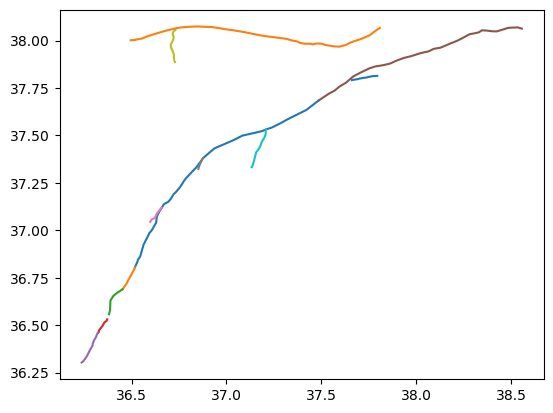

In [63]:
fault_file = '../../USGS/simple_fault_confident.lonlat'
faults_lola = readfile.read_gmt_lonlat_file(fault_file)

fig, ax = plt.subplots()
for fault in faults_lola:
    ax.plot(fault[:,0], fault[:,1])
ax.set_aspect('equal')
plt.show()

In [64]:
# translate lat/lon into local X/Y coordinates
atr = readfile.read_attribute(int_file)
coord = ut.coordinate(atr)
faults_xy = []
for fault_lola in faults_lola:
    ys, xs = coord.geo2radar(fault_lola[:,1], fault_lola[:,0])[:2]
    faults_xy.append([(x, y) for x, y in zip(xs, ys)])

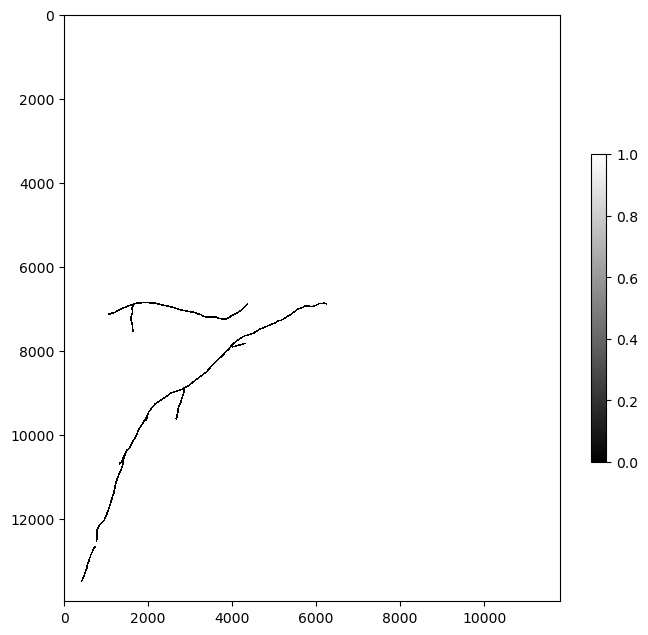

In [72]:
# rasterize
# link: https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
atr = readfile.read_attribute(int_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])

img = Image.new('L', (int(width), int(length)), 1)
for i, fault_xy in enumerate(faults_xy):
    ImageDraw.Draw(img).line(fault_xy, fill=0, width=40, joint='curve')
msk = np.array(img, dtype=np.bool_)

# plot
fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(msk, cmap='gray', interpolation='nearest')
fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

## Exclude pixels on water

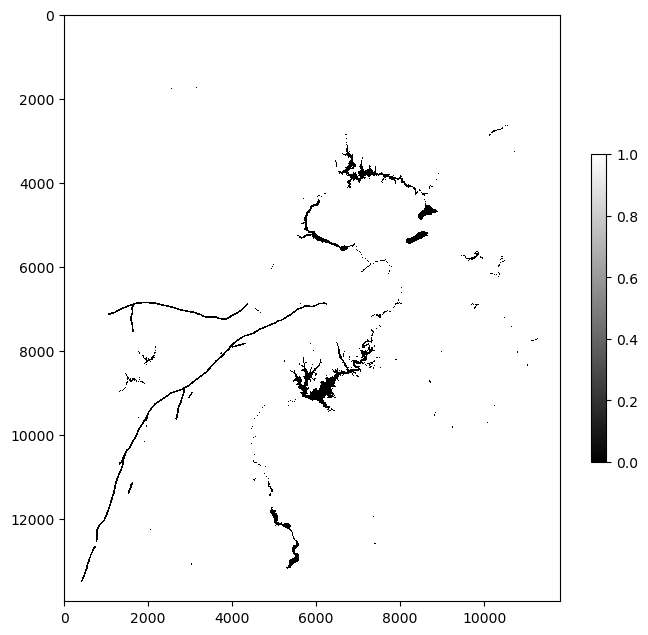

In [76]:
# generate water body file in geo-coordinates
#!prep_isce.py -f 190918-230215_2rlks_14alks.wbd -m ./../190918.track.xml -g ./
#!geocode.py 190918-230215_2rlks_14alks.wbd --lat-file 190918-230215_2rlks_14alks.lat --lon-file 190918-230215_2rlks_14alks.lon

# update mask based on water body
water_body_file = 'geo_190918-230215_2rlks_14alks.wbd'
water_body = readfile.read(water_body_file)[0]
msk[water_body!=0] = 0

# plot
fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(msk, cmap='gray', interpolation='nearest')
fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

## Exclude low coherent pixels

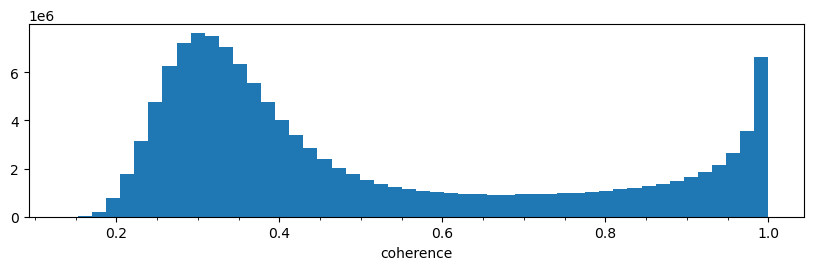

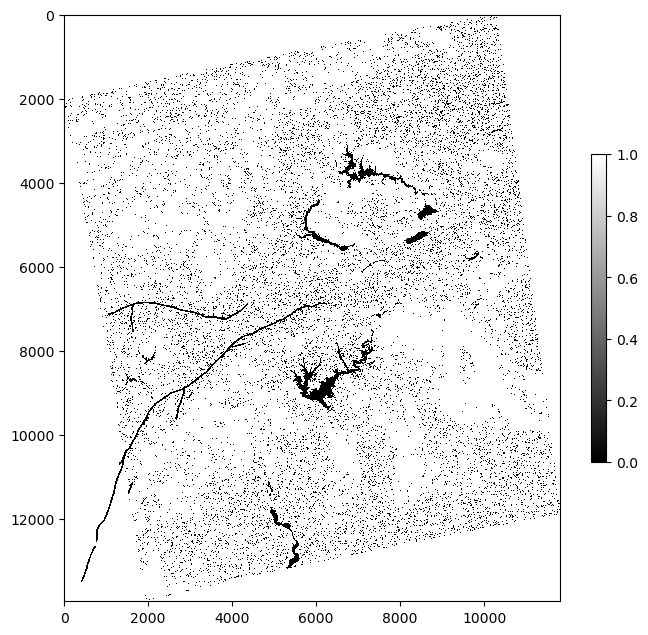

In [92]:
# update mask based on water body
cor, meta = readfile.read(cor_file)
cor[cor == 0] = np.nan
#msk[water_body!=0] = 0

# stats on the coherence
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 2.5])
im = ax.hist(cor.flatten(), bins=50)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('coherence')

# update mask based on coherence
msk[cor < 0.25] = 0

# plot
fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(msk, cmap='gray', interpolation='nearest')
fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

## Write mask file

In [95]:
meta['FILE_TYPE'] = '.msk'
meta['DATA_TYPE'] = 'bool'
writefile.write(msk, out_file=msk_file, metadata=meta, ref_file=cor_file)

write file: geo_190918-230215_2rlks_14alks.msk
write file: geo_190918-230215_2rlks_14alks.msk.rsc


'geo_190918-230215_2rlks_14alks.msk'

## Re-run via `unwrap.py`

```bash
unwrap.py -i geo_filt_190918-230215_2rlks_14alks.int -c geo_filt_190918-230215_2rlks_14alks.cor -o geo_filt_190918-230215_2rlks_14alks.unw --mask geo_190918-230215_2rlks_14alks.msk --max-comp 100 --defo-max 10
```